In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION/'

/content/drive/My Drive/PLANT DISEASE RECOGNITION


## Importing the required libraries

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling

## Data Augmentation transformations for the train dataset

## Loading the images from their directories

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
train_directory = 'datasets/train'
test_directory = 'datasets/valid'

train_dataset = image_dataset_from_directory(train_directory, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE, label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(test_directory, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE, label_mode = 'categorical')

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


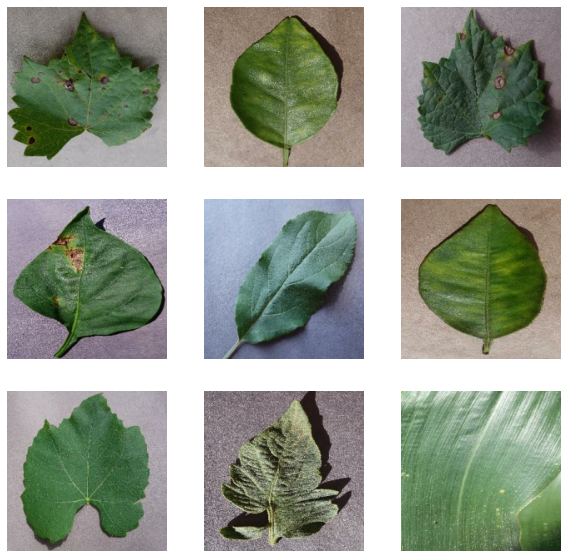

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

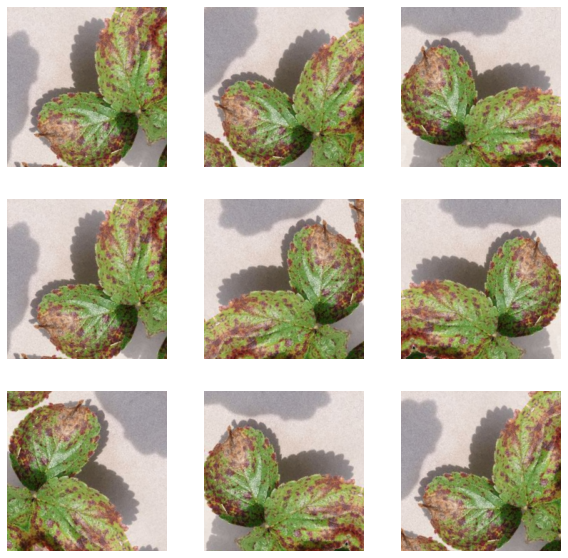

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Transfer learning with MobileNet architecture

In [9]:
def mobilenetmodel(image_shape = (224, 224), data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)

  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = True
  fine_tune_at = 120

  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  inputs = tf.keras.Input(shape=input_shape)

  X = data_augmentation(inputs)

  X = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

  X = base_model(X)

  X = tf.keras.layers.GlobalAveragePooling2D()(X) 

  X = tf.keras.layers.Dropout(rate = 0.2)(X)

  outputs = tfl.Dense(units = 38, activation = 'softmax')(X)

  model = tf.keras.Model(inputs, outputs)

  return model

In [10]:
mobilenet_model = mobilenetmodel(image_shape = (224, 224), data_augmentation = data_augmenter())
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [11]:
# Compiling the model with the optimizer and loss function 

mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = mobilenet_model.fit(train_dataset, validation_data = validation_dataset, epochs = 10)

Epoch 1/10
 193/1099 [====>.........................] - ETA: 4:02:44 - loss: 0.3965 - accuracy: 0.8832

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate the model on the Validation dataset
results = mobilenet_model.evaluate(validation_set_from_dir)

In [ ]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

In [ ]:
cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

In [ ]:
mkdir models

In [ ]:
# Save model in HDF5 format
mobilenet_model.save('models/mobilenet_model.h5')

In [ ]:
from tensorflow.python.keras.models import load_model
mobilenet_model = load_model('models/mobilenet_model.h5')

In [ ]:
mobilenet_model.summary()

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_model = converter.convert()
open("models/converted_model.tflite", "wb").write(tflite_model)

#### Accurate !

# Converting model to Tensorflow js

In [ ]:
!pip install tensorflowjs

In [ ]:
!pwd

In [ ]:
!mkdir tensorflowjs-model

In [ ]:
!tensorflowjs_converter --input_format keras models/mobilenet_model.h5 tensorflowjs-model/

In [ ]:
!zip -r tensorflowjs-model.zip tensorflowjs-model

## And we are done !